In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
import linearmodels
linearmodels.__version__

'4.17'

In [31]:
df_gdp = pd.read_pickle('gdpdata.pkl')
df_gdp.index = df_gdp['SurveyDate']
df_gdp = df_gdp.drop('SurveyDate', axis=1)

In [32]:
def bf_melt(df, col, dummy, listd):
    df[dummy] = 0
    dforig = df.copy()
    df['SD'] = df.index
    df = df.drop_duplicates(subset=['SD'], keep='first')
    df1 = df.copy()
    df1[listd] = 0
    df1['CurrentYearDiff'] = df1[col]
    df1[dummy] = 1
    df1 = df1.drop('SD', axis=1)
    dfnew = pd.concat([dforig, df1], axis=0)
    return dfnew.sort_index()

# load shocks

In [33]:
#EOP DEFINITION
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdf = mpdf.loc[(mpdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfwork = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].tail(1)
    #print(newdfwork)
    newdf = newdf.append(newdfwork)
newdf.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpr = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    #newdfprwork = prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1)
    newdfpr = newdfpr.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1))
newdfpr.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpc = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpc = newdfpc.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].tail(1))
newdfpc.index = dates_list

#SUM DEFINITION
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfsum = mpdf.loc[(mpdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfworksum = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].sum()
    #print(newdfwork)
    newdfsum = newdfsum.append(newdfwork, ignore_index = True)
newdfsum.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfprsum = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    #newdfprwork = prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1)
    newdfprsum = newdfprsum.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].sum(), ignore_index = True)
newdfprsum.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpcsum = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpcsum = newdfpcsum.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].sum(),ignore_index = True)
newdfpcsum.index = dates_list

# transform data into means

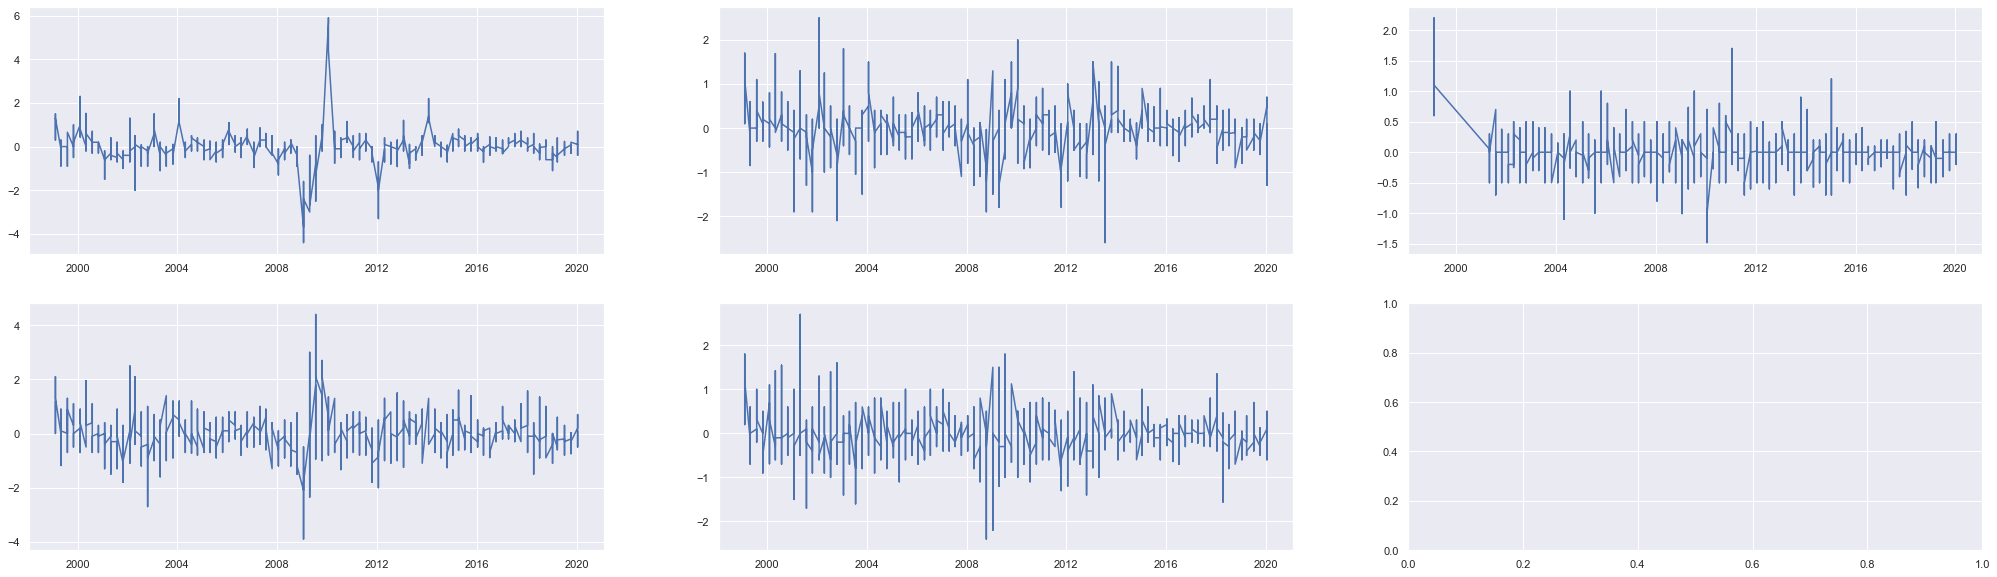

In [18]:
df_gdp['Current Year'] = df_gdp['Current Year'].astype(float)
df_gdp['One Year Ahead'] = df_gdp['One Year Ahead'].astype(float)
df_gdp['Longer Term'] = df_gdp['Longer Term'].astype(float)
df_gdp['Rolling1'] = df_gdp['Rolling1'].astype(float)
df_gdp['Rolling2'] = df_gdp['Rolling2'].astype(float)
dfgdp1 = df_gdp.sort_values(by=['Source', 'SurveyDate'],ascending = [True, True])
dfgdp1['CurrentYearDiff'] = dfgdp1['Current Year'].diff()
dfgdp1['OneYearDiff'] = dfgdp1['One Year Ahead'].diff()
dfgdp1['LongTermDiff'] = dfgdp1['Longer Term'].diff()
dfgdp1['R1'] = dfgdp1['Rolling1'].diff()
dfgdp1['R2'] = dfgdp1['Rolling2'].diff()
dfgdp1 = dfgdp1.sort_index()
#dfgdp1 = dfgdp1.dropna()
#dfgdp1.index = dfgdp1['SurveyDate']
fig, axs = plt.subplots(2, 3, figsize=(35, 10))
axs[0,0].plot(dfgdp1['CurrentYearDiff'].dropna().astype(float))
axs[0,1].plot(dfgdp1['OneYearDiff'].dropna().astype(float))
axs[0,2].plot(dfgdp1['LongTermDiff'].dropna().astype(float))
axs[1,0].plot(dfgdp1['R1'].dropna().astype(float))
axs[1,1].plot(dfgdp1['R2'].dropna().astype(float))

In [7]:
from linearmodels.datasets import jobtraining
data = jobtraining.load()
year = pd.Categorical(data.year)
data = data.set_index(['fcode', 'year'])
data['year'] = year

In [8]:
data

employ       sales   avgsal  scrap  rework  tothrs  union  grant  \
fcode  year                                                                     
410032 1987   100.0  47000000.0  35000.0    NaN     NaN    12.0      0      0   
       1988   131.0  43000000.0  37000.0    NaN     NaN     8.0      0      0   
       1989   123.0  49000000.0  39000.0    NaN     NaN     8.0      0      0   
410440 1987    12.0   1560000.0  10500.0    NaN     NaN    12.0      0      0   
       1988    13.0   1970000.0  11000.0    NaN     NaN    12.0      0      0   
...             ...         ...      ...    ...     ...     ...    ...    ...   
419483 1988   108.0  11500000.0  14810.0   25.0     NaN     0.0      1      0   
       1989   129.0  12000000.0  14227.0   30.0     NaN    20.0      1      0   
419486 1987    80.0   7000000.0  16000.0    NaN     NaN     0.0      0      0   
       1988    90.0   8500000.0  17000.0    NaN     NaN     0.0      0      0   
       1989   100.0   9900000.0  18000.0    NaN     NaN    40.0      0      1   

             d89  d88  ...   clscrap  cgrant  clemploy   clsales    lavgsal  \
fcode  year            ...                                                    
410032 1987    0    0  ...       NaN       0       NaN       NaN  10.463100   
       1988    0    1  ...       NaN       0  0.270027 -0.088949  10.518670   
       1989    1    0  ...       NaN       0 -0.063013  0.130621  10.571320   
410440 1987    0    0  ...       NaN       0       NaN       NaN   9.259130   
       1988    0    1  ...       NaN       0  0.080043  0.233347   9.305651   
...          ...  ...  ...       ...     ...       ...       ...        ...   
419483 1988    0    1  ...  0.223144       0 -0.208218  0.044453   9.603058   
       1989    1    0  ...  0.182321       0  0.177681  0.042559   9.562897   
419486 1987    0    0  ...       NaN       0       NaN       NaN   9.680344   
       1988    0    1  ...       NaN       0  0.117783  0.194157   9.740969   
       1989    1    0  ...       NaN       1  0.105360  0.152469   9.798127   

             clavgsal  cgrant_1    chrsemp  clhrsemp  year  
fcode  year                                                 
410032 1987       NaN       NaN        NaN       NaN  1987  
       1988  0.055570       0.0  -8.946565 -1.165385  1988  
       1989  0.052644       0.0   0.198597  0.047832  1989  
410440 1987       NaN       NaN        NaN       NaN  1987  
       1988  0.046520       0.0   0.000000  0.000000  1988  
...               ...       ...        ...       ...   ...  
419483 1988  0.059321       0.0   0.000000  0.000000  1988  
       1989 -0.040161       0.0   3.100775  1.411176  1989  
419486 1987       NaN       NaN        NaN       NaN  1987  
       1988  0.060625       0.0   0.000000  0.000000  1988  
       1989  0.057159       0.0  36.000000  3.610918  1989  

[471 rows x 29 columns]

In [9]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
exog_vars = ['grant', 'employ']
exog = sm.add_constant(data[exog_vars])
mod = RandomEffects(data[['clscrap']], exog)
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                clscrap   R-squared:                        0.0165
Estimator:              RandomEffects   R-squared (Between):              0.0314
No. Observations:                 105   R-squared (Within):               0.0015
Date:                Sat, Jun 13 2020   R-squared (Overall):              0.0199
Time:                        15:30:41   Log-likelihood                   -77.721
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.8542
Entities:                          53   P-value                           0.4286
Avg Obs:                       1.9811   Distribution:                   F(2,102)
Min Obs:                       1.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             0.8634
                            

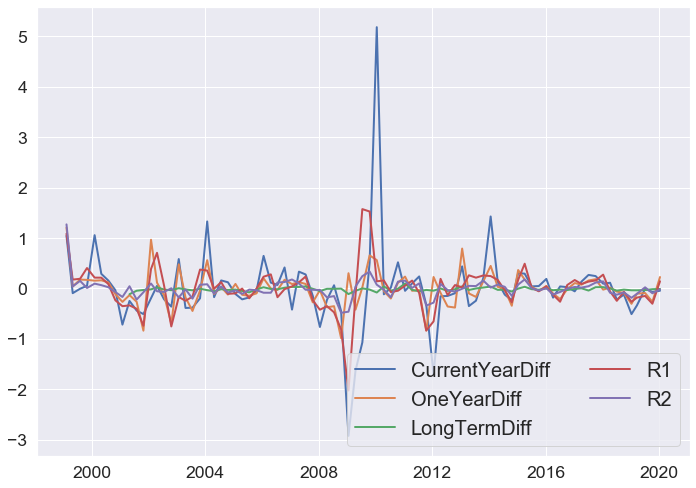

In [21]:
df1gdpmeans = dfgdp1.groupby('SurveyDate')[['CurrentYearDiff','OneYearDiff', 'LongTermDiff', 'R1', 'R2']].mean()
#df1gdpmeans.index = dfgdp1.index.unique()
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6)
plt.plot(df1gdpmeans, linewidth=2.0)
plt.legend(list(df1gdpmeans), ncol=2, loc='lower right', fontsize=20)

In [10]:
var = 'OIS_2Y'
dfgdp1 = pd.concat([dfgdp1, newdfpc], axis=1)
dfgdp1 = dfgdp1.dropna(subset = [var])
dfgdp1['date'] = dfgdp1.index
dfgdp1['D1'] = (dfgdp1.index.month.isin([1,2])==True)*1*dfgdp1[var]
dfgdp1['D2'] = (dfgdp1.index.month.isin([3,4])==True)*1*dfgdp1[var]
dfgdp1['D3'] = (dfgdp1.index.month.isin([7,8])==True)*1*dfgdp1[var]
dfgdp1['D4'] = (dfgdp1.index.month.isin([10,11])==True)*1*dfgdp1[var]
paneldf = dfgdp1.groupby(['Source', 'date']).mean()

In [21]:
exog_vars = ['D1', 'D2', 'D3']
exog = sm.add_constant(paneldf[exog_vars])
mod = PanelOLS(paneldf[['Current Year']], exog)
re_res = mod.fit()
print(re_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:           Current Year   R-squared:                        0.0303
Estimator:                   PanelOLS   R-squared (Between):             -0.0593
No. Observations:                4188   R-squared (Within):               0.0282
Date:                Sat, Jun 13 2020   R-squared (Overall):              0.0303
Time:                        16:17:42   Log-likelihood                   -7195.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      43.584
Entities:                         107   P-value                           0.0000
Avg Obs:                       39.140   Distribution:                  F(3,4184)
Min Obs:                       1.0000                                           
Max Obs:                       74.000   F-statistic (robust):             43.584
                            

In [12]:
exog_vars = ['OIS_2Y', 'D1', 'D2', 'D3']
exog = sm.add_constant(paneldf[exog_vars])
mod = PanelOLS(paneldf[['CurrentYearDiff']], exog)
re_res = mod.fit()
print(re_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:        CurrentYearDiff   R-squared:                        0.0176
Estimator:                   PanelOLS   R-squared (Between):             -0.0163
No. Observations:                3562   R-squared (Within):               0.0173
Date:                Sat, Jun 13 2020   R-squared (Overall):              0.0176
Time:                        15:31:13   Log-likelihood                   -4501.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      15.934
Entities:                         102   P-value                           0.0000
Avg Obs:                       34.922   Distribution:                  F(4,3557)
Min Obs:                       1.0000                                           
Max Obs:                       74.000   F-statistic (robust):             15.934
                            

In [13]:
exog_vars = ['OIS_2Y', 'D1', 'D2', 'D3']
#exog = sm.add_constant(paneldf[exog_vars])
mod = RandomEffects(paneldf[['Current Year']], paneldf[exog_vars])
re_res = mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:           Current Year   R-squared:                        0.0366
Estimator:              RandomEffects   R-squared (Between):              0.0039
No. Observations:                4188   R-squared (Within):               0.0379
Date:                Sat, Jun 13 2020   R-squared (Overall):              0.0241
Time:                        15:31:15   Log-likelihood                   -7204.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      39.718
Entities:                         107   P-value                           0.0000
Avg Obs:                       39.140   Distribution:                  F(4,4184)
Min Obs:                       1.0000                                           
Max Obs:                       74.000   F-statistic (robust):             39.718
                            

In [14]:
exog_vars = paneldf[['OIS_2Y', 'D1', 'D2', 'D3']]
#exog = sm.add_constant(paneldf[exog_vars])
mod = linearmodels.FirstDifferenceOLS(paneldf[['Current Year']], exog_vars)
re_res = mod.fit()
print(re_res)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:           Current Year   R-squared:                        0.0270
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.0112
No. Observations:                3436   R-squared (Within):               0.0284
Date:                Sat, Jun 13 2020   R-squared (Overall):              0.0204
Time:                        15:31:17   Log-likelihood                   -5085.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      23.832
Entities:                         107   P-value                           0.0000
Avg Obs:                       39.140   Distribution:                  F(4,3432)
Min Obs:                       1.0000                                           
Max Obs:                       74.000   F-statistic (robust):             23.832
                            

In [76]:
from linearmodels.datasets import mroz
data = mroz.load()
data = data[['hours','educ','age','kidslt6','nwifeinc','lwage','exper','expersq']]
data = data.dropna()
from linearmodels import IV2SLS, IV3SLS, SUR, IVSystemGMM


In [107]:
dataols['b1'] = 1
dataols['b2'] = 1
dataols['b3'] = 1
dataols['b4'] = 1
dataols['b5'] = 1
dataols['b6'] = 1
dataols['b7'] = 1

In [110]:
'''    error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        error8 = mp*(rolling1-mp*(1*c0+3/4*c1+1/2*c2))
        error7 = mp*(rolling2-mp*(0*c0+1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6))'''
equations = dict(ny1='OneYearDiff ~ b1:OIS_2Y**1/4+b2:OIS_2Y**1/2+b3:OIS_2Y**3/4+b4:OIS_2Y+b5:OIS_2Y**3/4+b6:OIS_2Y**1/2+b7:OIS_2Y**1/4+D2:OIS_2Y',
                 ny2='OneYearDiff ~ 1/2*b1*OIS_2Y+3/4*b2*OIS_2Y+1*b3*OIS_2Y+3/4*b4*OIS_2Y+1/2*b5*OIS_2Y+1/4*b6*OIS_2Y+0*b7*OIS_2Y+D3*OIS_2Y',
                 ny3='OneYearDiff ~ 3/4*b1*OIS_2Y+1*b2*OIS_2Y+3/4*b3*OIS_2Y+1/2*b4*OIS_2Y+1/4*b5*OIS_2Y+0*b6*OIS_2Y+0*b7*OIS_2Y+D4*OIS_2Y',
                 cy1='CurrentYearDiff ~3/4*b1*OIS_2Y+1/2*b2*OIS_2Y+1/4*b3*OIS_2Y+0*b4*OIS_2Y+0*b5*OIS_2Y+0*b6*OIS_2Y+0*b7*OIS_2Y+D2*OIS_2Y',
                 cy2='CurrentYearDiff ~1/2*b1*OIS_2Y+1/4*b2*OIS_2Y+0*b3*OIS_2Y+0*b4*OIS_2Y+0*b5*OIS_2Y+0*b6*OIS_2Y+0*b7*OIS_2Y+D3*OIS_2Y',
                 cy3='CurrentYearDiff ~1/4*b1*OIS_2Y+0*b2*OIS_2Y+0*b3*OIS_2Y+0*b4*OIS_2Y+0*b5*OIS_2Y+0*b6*OIS_2Y+0*b7*OIS_2Y+D4*OIS_2Y',
                 r1='R1 ~ 1*b1*OIS_2Y+3/4*b2*OIS_2Y+1/2*b3*OIS_2Y+0*b4*OIS_2Y+0*b5*OIS_2Y+0*b6*OIS_2Y+0*b7*OIS_2Y',
                 r2='R2 ~ 0*b1*OIS_2Y+1/4*b2*OIS_2Y+1/2*b3*OIS_2Y+3/4*b4*OIS_2Y+1*b5*OIS_2Y+3/4*b6*OIS_2Y+1/2*b7*OIS_2Y')
system_gmm = IVSystemGMM.from_formula(equations, dataols, weight_type='unadjusted')
system_gmm_res = system_gmm.fit(cov_type='unadjusted')
print(system_gmm_res)

PatsyError: numbers besides '0' and '1' are only allowed with **
    0 + b1:OIS_2Y**1/4+b2:OIS_2Y**1/2+b3:OIS_2Y**3/4+b4:OIS_2Y+b5:OIS_2Y**3/4+b6:OIS_2Y**1/2+b7:OIS_2Y**1/4+D2:OIS_2Y
                     ^

In [ ]:
    error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        error8 = mp*(rolling1-mp*(1*c0+3/4*c1+1/2*c2))
        error7 = mp*(rolling2-mp*(0*c0+1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6))

In [15]:
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 16)
        kwds.setdefault('k_params', 7)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6= params
        cs = np.asarray([c0, c1, c2, c3, c4, c5, c6])
        endog = self.endog
        exog = self.exog
        mp1 = exog[:,0:4]
        instr = exog[:,4:]
        error1 =  endog-np.multiply(mp1,np.dot(q1m,np.transpose(cs)))
        error2 =  endog-np.multiply(mp1,np.dot(q2m,np.transpose(cs)))
        error3 =  endog-np.multiply(mp1,np.dot(q3m,np.transpose(cs)))
        error4 =  endog-np.multiply(mp1,np.dot(q4m,np.transpose(cs)))
        g = np.column_stack((error1, error2, error3, error4))
        g = np.multiply(instr,g)
        return g

In [16]:
#order data
dataols = pd.concat([df1gdpmeans, newdfpc], axis=1)
var = 'OIS_2Y'

dataols = dataols.dropna(subset = [var])

dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#next year dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1*dataols[var]
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1*dataols[var]
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1*dataols[var]
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1*dataols[var]
exog = dataols[[var, var, var, var, 'D1', 'D1','D1','D1','D2','D2','D2','D2',
                'D3','D3','D3','D3', 'D4','D4','D4','D4']]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'R1', 'R2']].copy()
instr = np.asarray(exog.iloc[:, 4:])
model = mpGMM(endog, exog, None)
beta0 = np.zeros((1, 7))
#initial values
#w0inv = np.dot(instr.T, instr)/len(endog)
res = model.fititer(beta0, maxiter=1000, optim_method='nm',  weights_method='cov',
                    wargs={'centered':False})
w0 = res[1]
inv_weights = np.linalg.inv(w0)
res = model.fit(beta0, maxiter=2,  inv_weights =inv_weights, optim_method='nm', weights_method='cov',
                wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']))

NameError: name 'df1gdpmeans' is not defined

In [29]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 8)
        kwds.setdefault('k_params', 7)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        rolling1 = endog[:,2]
        rolling2 = endog[:,3]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        error8 = mp*(rolling1-mp*(1*c0+3/4*c1+1/2*c2))
        error7 = mp*(rolling2-mp*(0*c0+1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, error7, error8))
        return g

#order data
dataols = pd.concat([dfgdp1, newdfpc], axis=1)
var = 'OIS_2Y'
dataols = dataols.dropna(subset=[var, 'CurrentYearDiff', 'OneYearDiff', 'R1', 'R2'])
#time periods
#dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
dataols = dataols.loc[dataols.index>'2003-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1*dataols[var]
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1*dataols[var]
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1*dataols[var]
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1*dataols[var]
exog = dataols[['D1', 'D2', 'D3', 'D4',  var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'R1', 'R2']]
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 7))
res = model.fititer(beta0, maxiter=1000, optim_method='nm',  weights_method='cov',
                    wargs={'centered':False})
w0 = res[1]
inv_weights = np.linalg.inv(w0)
res = model.fit(beta0, maxiter=2,  inv_weights =inv_weights, optim_method='nm', weights_method='cov',
                wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6']))

Optimization terminated successfully.
         Current function value: 0.049564
         Iterations: 481
         Function evaluations: 726
Optimization terminated successfully.
         Current function value: 0.007540
         Iterations: 709
         Function evaluations: 1062
Optimization terminated successfully.
         Current function value: 0.007727
         Iterations: 463
         Function evaluations: 709
Optimization terminated successfully.
         Current function value: 0.007736
         Iterations: 124
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 0.007734
         Iterations: 106
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 0.007733
         Iterations: 211
         Function evaluations: 346
Optimization terminated successfully.
         Current function value: 0.007733
         Iterations: 91
         Function evaluations: 167
Optimization termina

In [108]:
dataols

,Source,Current Year,One Year Ahead,Rolling1,Rolling2,Longer Term,CurrentYearDiff,OneYearDiff,LongTermDiff,R1,...,D2,D3,D4,b1,b2,b3,b4,b5,b6,b7
SurveyDate,,,,,,,,,,,,,,,,,,,,,
2003-01-27,89,1.400000,2.400000,1.700000,2.400000,2.500000,0.600000,0.400000,0.000000,-0.200000,...,0.0,0.0,0.0,1,1,1,1,1,1,1
2003-01-27,33,1.500000,2.000000,1.800000,2.200000,2.500000,0.700000,0.200000,0.000000,-0.100000,...,0.0,0.0,0.0,1,1,1,1,1,1,1
2003-01-27,95,1.400000,2.300000,1.500000,2.300000,2.500000,0.500000,0.300000,-0.100000,-0.500000,...,0.0,0.0,0.0,1,1,1,1,1,1,1
2003-01-27,71,1.200000,2.200000,1.600000,2.000000,2.000000,0.400000,0.200000,0.000000,-0.300000,...,0.0,0.0,0.0,1,1,1,1,1,1,1
2003-01-27,53,1.500000,2.300000,1.400000,2.400000,2.000000,0.800000,0.500000,-0.300000,-0.100000,...,0.0,0.0,0.0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-13,95,0.973742,0.947133,1.028816,0.926656,1.239834,-0.180893,0.000000,0.200628,0.083166,...,0.0,0.0,0.0,1,1,1,1,1,1,1
2020-01-13,93,1.100000,1.300000,1.100000,1.200000,NaN,0.100000,0.200000,NaN,0.300000,...,0.0,0.0,0.0,1,1,1,1,1,1,1
2020-01-13,85,0.876510,1.222716,0.871461,1.269435,1.250000,-0.189126,0.467357,-0.021844,0.232878,...,0.0,0.0,0.0,1,1,1,1,1,1,1


In [25]:
from patsy import EvalEnvironment, ModelDesc

In [28]:
dataols

,Source,Current Year,One Year Ahead,Rolling1,Rolling2,Longer Term,CurrentYearDiff,OneYearDiff,LongTermDiff,R1,...,IT10Y,STOXX50,SX7E,EURUSD,EURGBP,EURJPY,D1,D2,D3,D4
SurveyDate,,,,,,,,,,,,,,,,,,,,,
2003-01-27,89,1.400000,2.400000,1.700000,2.400000,2.500000,0.600000,0.400000,0.000000,-0.200000,...,0.750000,1.079402,1.166337,-0.176287,-0.053613,0.017977,1.950000,0.0,0.0,0.0
2003-01-27,33,1.500000,2.000000,1.800000,2.200000,2.500000,0.700000,0.200000,0.000000,-0.100000,...,0.750000,1.079402,1.166337,-0.176287,-0.053613,0.017977,1.950000,0.0,0.0,0.0
2003-01-27,95,1.400000,2.300000,1.500000,2.300000,2.500000,0.500000,0.300000,-0.100000,-0.500000,...,0.750000,1.079402,1.166337,-0.176287,-0.053613,0.017977,1.950000,0.0,0.0,0.0
2003-01-27,71,1.200000,2.200000,1.600000,2.000000,2.000000,0.400000,0.200000,0.000000,-0.300000,...,0.750000,1.079402,1.166337,-0.176287,-0.053613,0.017977,1.950000,0.0,0.0,0.0
2003-01-27,53,1.500000,2.300000,1.400000,2.400000,2.000000,0.800000,0.500000,-0.300000,-0.100000,...,0.750000,1.079402,1.166337,-0.176287,-0.053613,0.017977,1.950000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-13,95,0.973742,0.947133,1.028816,0.926656,1.239834,-0.180893,0.000000,0.200628,0.083166,...,3.250003,0.509546,1.683207,-0.008980,0.041382,0.210587,0.409999,0.0,0.0,0.0
2020-01-13,93,1.100000,1.300000,1.100000,1.200000,NaN,0.100000,0.200000,NaN,0.300000,...,3.250003,0.509546,1.683207,-0.008980,0.041382,0.210587,0.409999,0.0,0.0,0.0
2020-01-13,85,0.876510,1.222716,0.871461,1.269435,1.250000,-0.189126,0.467357,-0.021844,0.232878,...,3.250003,0.509546,1.683207,-0.008980,0.041382,0.210587,0.409999,0.0,0.0,0.0


In [36]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        rolling1 = endog[:,2]
        rolling2 = endog[:,3]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error0 = dQ1*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7))
        error1 = dQ2*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6))
        error2 = dQ3*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5))
        error3 = dQ4*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4))
        #current year forecasts
        error9 = dQ1*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3))
        error4 = dQ2*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2))
        error5 = dQ3*(currentY-mp*(1/2*c0+1/4*c1))
        error6 = dQ4*(currentY-mp*(1/4*c0))
        #rolling forecasts
        error8 = mp*(rolling1-mp*(c3))
        error7 = mp*(rolling2-mp*(c7))
        g = np.column_stack((error0, error9, error1, error2, error3, error4, error5, error6, error7, error8))
        return g

#order data
dataols = pd.concat([dfgdp1, newdfpc], axis=1)
var = 'OIS_2Y'
dataols = dataols.dropna(subset=[var, 'CurrentYearDiff', 'OneYearDiff', 'R1', 'R2'])
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1*dataols[var]
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1*dataols[var]
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1*dataols[var]
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1*dataols[var]
exog = dataols[['D1', 'D2', 'D3', 'D4',  var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'R1', 'R2']]
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=1000, optim_method='bfgs',  weights_method='cov',
                    wargs={'centered':False})
w0 = res[1]
inv_weights = np.linalg.inv(w0)
res = model.fit(beta0, maxiter=2,  inv_weights =inv_weights, optim_method='bfgs', weights_method='cov',
                wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.001532
         Iterations: 18
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.002094
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.002155
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.002146
         Iterations: 14
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 0.002145
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.002145
         Iterations: 5
         Function evaluations: 9
    